# 1. Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance


# 2. Tiền xử lý dữ liệu

In [42]:
df = pd.read_csv("D:/do_an_khdl/vehicle_count_congestion.csv", index_col=0)

In [43]:
# Kiểm tra sơ bộ
df.head()

,Original_Filename,Total_Vehicles,Motorcycles,Cars,Trucks
Image_Index,,,,,
1,001.jpg,15,7,5,3
2,002.jpg,7,3,3,1
3,003.jpg,6,1,4,1
4,004.jpg,5,1,3,1
5,005.jpg,10,2,6,2


In [44]:
# Tạo cột TruckCar_Percentage = (Cars + Trucks) / Total_Vehicle * 100
df['TruckCar_Percentage'] = ((df['Cars'] + df['Trucks']) / df['Total_Vehicles']) * 100

# Xuất lại ra CSV mới (hoặc ghi đè)
df.to_csv("vehicle_count_with_percentage.csv", index=False)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 1 to 2640
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Original_Filename    2640 non-null   object 
 1   Total_Vehicles       2640 non-null   int64  
 2   Motorcycles          2640 non-null   int64  
 3   Cars                 2640 non-null   int64  
 4   Trucks               2640 non-null   int64  
 5   TruckCar_Percentage  2640 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 144.4+ KB


In [46]:
df.head()

,Original_Filename,Total_Vehicles,Motorcycles,Cars,Trucks,TruckCar_Percentage
Image_Index,,,,,,
1,001.jpg,15,7,5,3,53.333333
2,002.jpg,7,3,3,1,57.142857
3,003.jpg,6,1,4,1,83.333333
4,004.jpg,5,1,3,1,80.000000
5,005.jpg,10,2,6,2,80.000000


In [47]:
def is_congested(row, threshold=40):
    # Ánh xạ các cột DataFrame với tham số hàm
    total = row['Total_Vehicles']
    moto = row['Motorcycles']
    car = row['Cars']
    truck = row['Trucks']
    sum_pct = row['TruckCar_Percentage'] # sum_pct đã được tính ở trên

    if total == moto and total > 30:
        return 1
    elif total == (car + truck) and total > 7:
        return 1
    elif (car + truck) > 5:
        return 1
    elif total > 4 and sum_pct > 50:
        return 1
    elif total >= threshold:
        return 1
    else:
        return 0

In [48]:
# Áp dụng hàm để tạo nhãn mới với ngưỡng tổng quát mặc định là 40
df['Congestion_Label'] = df.apply(is_congested, axis=1, threshold=40)

print(df[['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage', 'Congestion_Label']].head())

             Total_Vehicles  Motorcycles  Cars  Trucks  TruckCar_Percentage  \
Image_Index                                                                   
1                        15            7     5       3            53.333333   
2                         7            3     3       1            57.142857   
3                         6            1     4       1            83.333333   
4                         5            1     3       1            80.000000   
5                        10            2     6       2            80.000000   

             Congestion_Label  
Image_Index                    
1                           1  
2                           1  
3                           1  
4                           1  
5                           1  


1. Ma trận tương quan

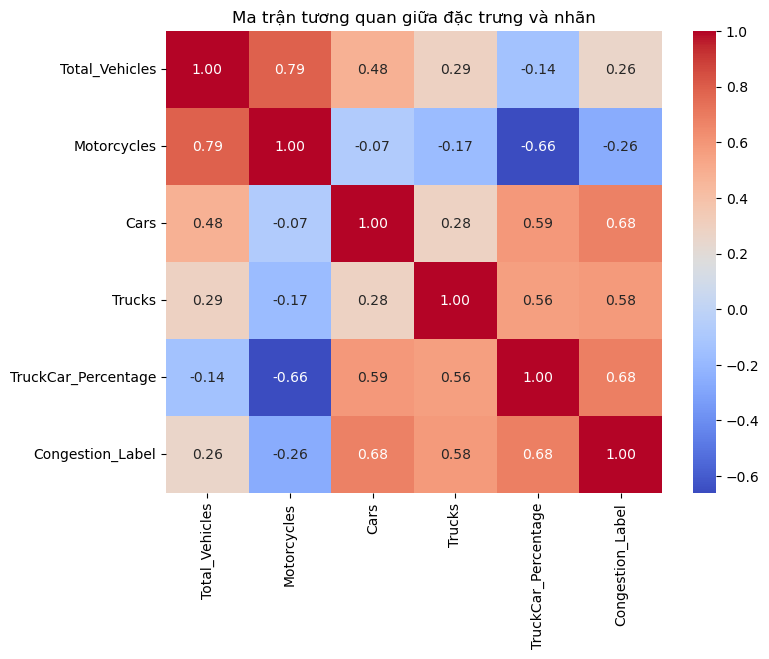

In [49]:
# Ghép X và y lại thành một DataFrame
df_corr = pd.concat([X, y], axis=1)

# Tính ma trận tương quan Pearson
corr_matrix = df_corr.corr()


plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa đặc trưng và nhãn")
plt.show()

Nhận xét: các mối tương quan


  *   Trucks và TruckCar_Percentage     0.84
  *   Total_Vehicles và Motorcycles  0.79
có khả năng bị đa cộng tuyến 

  *  TruckCar_Percentage
  *  Cars
  *  Truck
có độ tương quan với nhãn khá cao 


2. Phân phối và Đặc điểm của các Biến

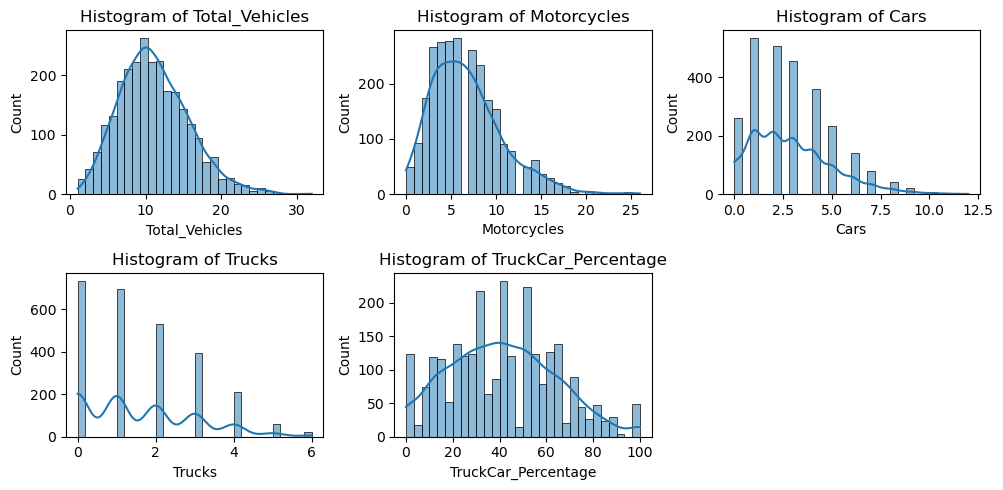

In [50]:
num_cols = ['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage']
plt.figure(figsize=(10,5))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

In [51]:
num_cols = ['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage']
# mean (Trung bình), std (Độ lệch chuẩn), và các Tứ phân vị (25%, 50%, 75%)
descriptive_stats = df[num_cols].describe().T
# Chọn các cột cần thiết và làm tròn 2 chữ số thập phân
report_table_histogram = descriptive_stats[['count', 'mean', 'std', 'min', '50%', 'max']].round(2)
print("Bảng Thống kê Mô tả Phân phối")
print(report_table_histogram)

Bảng Thống kê Mô tả Phân phối
                      count   mean    std  min   50%    max
Total_Vehicles       2640.0  11.16   4.53  1.0  11.0   32.0
Motorcycles          2640.0   6.72   3.97  0.0   6.0   26.0
Cars                 2640.0   2.86   2.06  0.0   3.0   12.0
Trucks               2640.0   1.58   1.41  0.0   1.0    6.0
TruckCar_Percentage  2640.0  41.10  22.97  0.0  40.0  100.0


3. box plot

C:\Users\HP\AppData\Local\Temp\ipykernel_13324\2738398867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Congestion_Label', y=col, data=df, palette='Set2')
C:\Users\HP\AppData\Local\Temp\ipykernel_13324\2738398867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Congestion_Label', y=col, data=df, palette='Set2')
C:\Users\HP\AppData\Local\Temp\ipykernel_13324\2738398867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Congestion_Label', y=col, data=df, palette='Set2')
C:\Users\HP\AppData\Local\Temp\ipykernel_13324\27383988

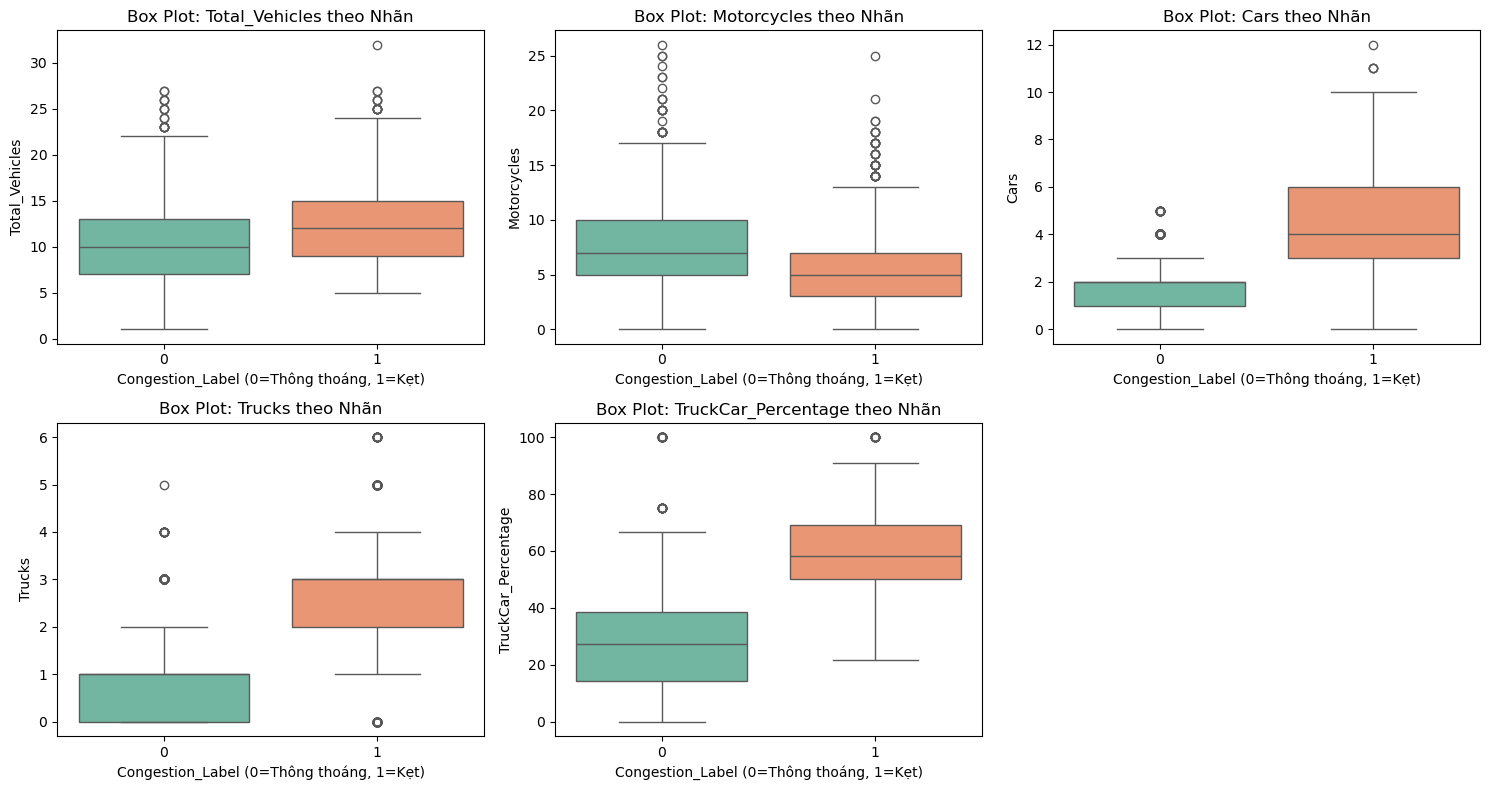

In [52]:

# Các đặc trưng cần vẽ
features = ['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage']

plt.figure(figsize=(15, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Congestion_Label', y=col, data=df, palette='Set2')
    plt.title(f'Box Plot: {col} theo Nhãn')
    plt.xlabel("Congestion_Label (0=Thông thoáng, 1=Kẹt)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

4. scatter plot

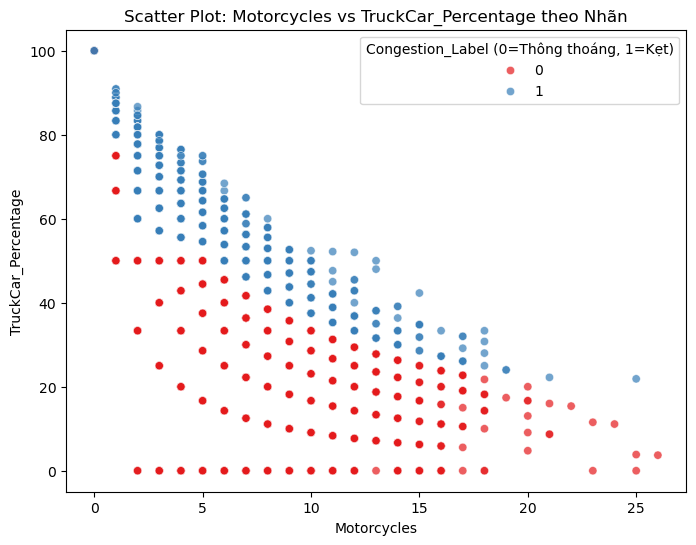

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Motorcycles', 
    y='TruckCar_Percentage', 
    hue='Congestion_Label', 
    data=df, 
    palette='Set1', 
    alpha=0.7
)
plt.title("Scatter Plot: Motorcycles vs TruckCar_Percentage theo Nhãn")
plt.xlabel("Motorcycles")
plt.ylabel("TruckCar_Percentage")
plt.legend(title="Congestion_Label (0=Thông thoáng, 1=Kẹt)")
plt.show()

5. So sánh Đặc trưng theo Nhãn Tắc nghẽn

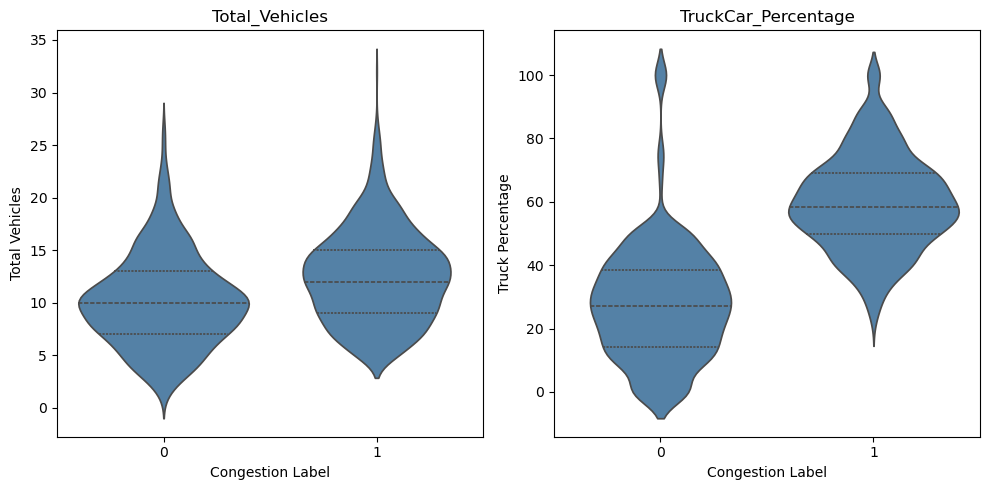

In [54]:
comparison_cols = ['Total_Vehicles', 'TruckCar_Percentage']
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.violinplot(x='Congestion_Label', y='Total_Vehicles', data=df, inner='quartile', color='steelblue')
plt.title('Total_Vehicles')
plt.xlabel('Congestion Label')
plt.ylabel('Total Vehicles')
plt.subplot(1, 2, 2)
sns.violinplot(x='Congestion_Label', y='TruckCar_Percentage', data=df, inner='quartile', color='steelblue')
plt.title('TruckCar_Percentage')
plt.xlabel('Congestion Label')
plt.ylabel('Truck Percentage')
plt.tight_layout()
plt.show()

In [55]:
comparison_cols = ['Total_Vehicles', 'TruckCar_Percentage']
agg_funcs = [
    ('Trung vị (Median)', 'median'),
    ('Trung bình (Mean)', 'mean'),
    ('Q1 (25%)', lambda x: x.quantile(0.25)),
    ('Q3 (75%)', lambda x: x.quantile(0.75)),
    ('Độ lệch chuẩn (Std)', 'std')
]
comparison_table = df.groupby('Congestion_Label')[comparison_cols].agg(agg_funcs)
comparison_table = comparison_table.stack(level=0).T.round(2)
print("Bảng So sánh Chỉ số Thống kê theo Nhãn Tắc nghẽn")
print(comparison_table)

Bảng So sánh Chỉ số Thống kê theo Nhãn Tắc nghẽn
Congestion_Label                 0                                  1  \
                    Total_Vehicles TruckCar_Percentage Total_Vehicles   
Trung vị (Median)            10.00               27.27          12.00   
Trung bình (Mean)            10.17               27.85          12.54   
Q1 (25%)                      7.00               14.29           9.00   
Q3 (75%)                     13.00               38.46          15.00   
Độ lệch chuẩn (Std)           4.37               18.03           4.39   

Congestion_Label                         
                    TruckCar_Percentage  
Trung vị (Median)                 58.33  
Trung bình (Mean)                 59.65  
Q1 (25%)                          50.00  
Q3 (75%)                          69.23  
Độ lệch chuẩn (Std)               14.87  


C:\Users\HP\AppData\Local\Temp\ipykernel_13324\501524170.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  comparison_table = comparison_table.stack(level=0).T.round(2)


In [56]:
def is_congested(row, threshold=40):
    """
    Phân loại tình trạng kẹt xe (1) hoặc thông thoáng (0).
    Yêu cầu tổng số xe phải trên 5 để phân loại là Kẹt xe (1) dựa trên tỷ lệ xe lớn.
    """
    # Ánh xạ các cột DataFrame với tham số hàm
    total = row['Total_Vehicles']
    motorcycles = row['Motorcycles']
    cars = row['Cars']
    trucks = row['Trucks']
    truck_car_percentage = row['TruckCar_Percentage']  # tỷ lệ xe tải/xe con

    # --- Quy tắc Kẹt xe do Mật độ Xe máy Cao ---
    # Trường hợp kẹt do xe máy thường liên quan đến mật độ/tổng số lượng rất cao.
    if total >= 20 and motorcycles >= 15 and truck_car_percentage < 30:
         return 1 # Kẹt xe (1) do mật độ xe máy

    # --- Quy tắc chính cho Kẹt xe (Xe lớn) ---
    if (total > 5) and (truck_car_percentage > threshold) and (motorcycles <= 7):
        # Thêm điều kiện phụ: số lượng xe tải/cars cao hơn ngưỡng
        if (trucks >= 2) or (cars >= 3):
            return 1  # Kẹt xe (1)

    # --- Quy tắc Phụ cho Kẹt xe (Xe lớn) ---
    if (total > 5) and (truck_car_percentage >= 60):
        return 1  # Kẹt xe (1)

    # --- Quy tắc Ưu tiên Thông thoáng ---
    # Quy tắc này vẫn được áp dụng để phủ các trường hợp thông thoáng rõ ràng.
    if (truck_car_percentage < 30) and (motorcycles > 6) and (total < 18):
        return 0  # Thông thoáng (0)
    
    # --- Trường hợp mặc định/Trung gian ---
    return 0  # Mặc định là Thông thoáng (0)

In [57]:
# Áp dụng hàm để tạo nhãn mới với ngưỡng tổng quát mặc định là 40
df['Congestion_Label'] = df.apply(is_congested, axis=1, threshold=40)

print(df[['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage', 'Congestion_Label']].head())

             Total_Vehicles  Motorcycles  Cars  Trucks  TruckCar_Percentage  \
Image_Index                                                                   
1                        15            7     5       3            53.333333   
2                         7            3     3       1            57.142857   
3                         6            1     4       1            83.333333   
4                         5            1     3       1            80.000000   
5                        10            2     6       2            80.000000   

             Congestion_Label  
Image_Index                    
1                           1  
2                           1  
3                           1  
4                           0  
5                           1  


6. Phân tích Cân bằng Lớp (Class Imbalance)

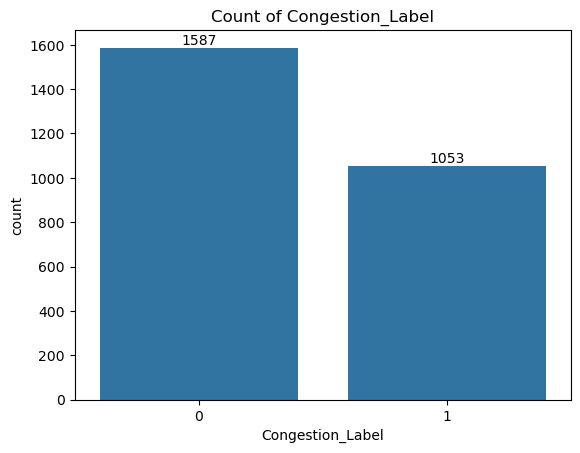

In [58]:
vax = sns.countplot(x='Congestion_Label', data=df)
for p in vax.patches:
    vax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Count of Congestion_Label')
plt.show()

In [59]:
label_counts = df['Congestion_Label'].value_counts()
total_samples = label_counts.sum()
label_percentages = (label_counts / total_samples * 100).round(2)
report_table_count = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentages
})
print("Bảng Cân bằng Dữ liệu theo Congestion_Label")
print(report_table_count)

Bảng Cân bằng Dữ liệu theo Congestion_Label
                  Count  Percentage (%)
Congestion_Label                       
0                  1587           60.11
1                  1053           39.89


# 3. Huấn luyện mô hình

1. Chia tập train/test

In [60]:
# Giả sử cột nhãn là 'label', các cột còn lại là đặc trưng
X = df[['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage']]# hoặc thêm các cột khác nếu có
y = df['Congestion_Label']

# Chia train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
X_train.shape 

(2112, 5)

In [62]:
X_test.shape

(528, 5)

2. Kiểm tra độ lệch nhãn

In [63]:
print(df['Congestion_Label'].value_counts())

Congestion_Label
0    1587
1    1053
Name: count, dtype: int64


In [64]:
print(df['Congestion_Label'].value_counts(normalize=True))

Congestion_Label
0    0.601136
1    0.398864
Name: proportion, dtype: float64


3. Mô hình Logistc Regression

In [65]:

# Chuẩn hóa dữ liệu
scaler_log = StandardScaler()
X_train_scaled = scaler_log.fit_transform(X_train)
X_test_scaled = scaler_log.transform(X_test)

# Huấn luyện mô hình
log_model = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Lưu model và scaler cho Logistic Regression
joblib.dump(log_model, r"D:\do_an_khdl\full_code\models\logistic_model.pkl")
joblib.dump(scaler_log, r"D:\do_an_khdl\full_code\models\scaler_log.pkl")


Logistic Regression
Accuracy: 0.8276515151515151
[[277  40]
 [ 51 160]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       317
           1       0.80      0.76      0.78       211

    accuracy                           0.83       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.83      0.83      0.83       528



['D:\\do_an_khdl\\full_code\\models\\scaler_log.pkl']

In [66]:
# Đặc trưng ảnh hưởng tới kẹt xe

Đặc trưng Total_Vehicles có hệ số: 0.1317
Đặc trưng Motorcycles có hệ số: -0.3279
Đặc trưng Cars có hệ số: 0.4859
Đặc trưng Trucks có hệ số: 0.6371
Đặc trưng TruckCar_Percentage có hệ số: 1.2593


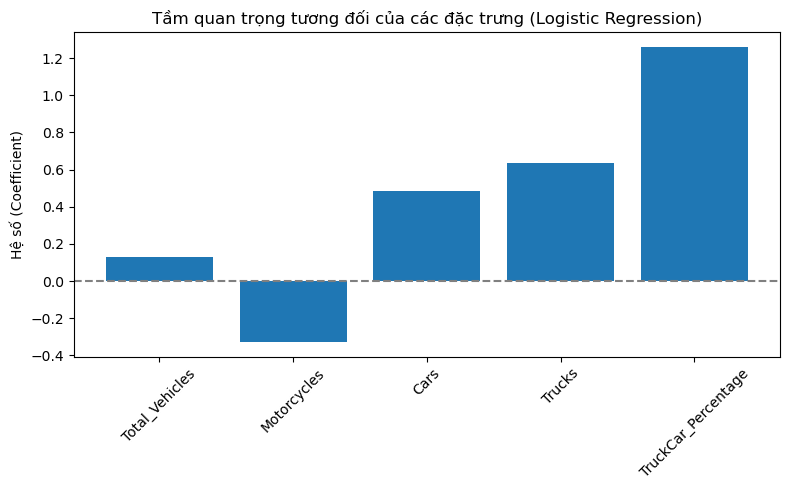

In [67]:
coefficients = log_model.coef_[0]  # Vì đây là mô hình nhị phân
feature_names = X_train.columns  # lấy đúng tên đặc trưng đã dùng

for i, coef in enumerate(coefficients):
    print(f'Đặc trưng {feature_names[i]} có hệ số: {coef:.4f}')

plt.figure(figsize=(8, 5))
plt.bar(feature_names, coefficients)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Tầm quan trọng tương đối của các đặc trưng (Logistic Regression)')
plt.ylabel('Hệ số (Coefficient)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Mô hình Random Forest

In [68]:
# Chuẩn hóa dữ liệu
scaler_rf = StandardScaler()
X_train_scaled = scaler_rf.fit_transform(X_train)
X_test_scaled = scaler_rf.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Lưu model và scaler cho RF
joblib.dump(log_model, r"D:\do_an_khdl\full_code\models\rf_model.pkl")
joblib.dump(scaler_log, r"D:\do_an_khdl\full_code\models\scaler_rf.pkl")


Random Forest
Accuracy: 1.0
[[317   0]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       211

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528



['D:\\do_an_khdl\\full_code\\models\\scaler_rf.pkl']

5. Test độ quan trọng cho biết đặc trưng nào được dùng nhiều nhất để phân chia cây, nhưng không có chiều hướng

Đặc trưng Total_Vehicles có độ quan trọng: 0.157
Đặc trưng Motorcycles có độ quan trọng: 0.231
Đặc trưng Cars có độ quan trọng: 0.115
Đặc trưng Trucks có độ quan trọng: 0.070
Đặc trưng TruckCar_Percentage có độ quan trọng: 0.428


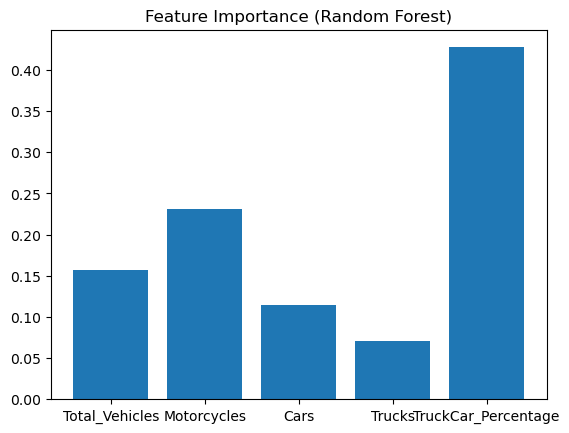

In [69]:
importance = rf_model.feature_importances_
for i, v in enumerate(importance):
    print(f'Đặc trưng {X.columns[i]} có độ quan trọng: {v:.3f}')

plt.bar(X.columns, importance)
plt.title("Feature Importance (Random Forest)")
plt.show()

6. Test mối quan hệ giữa một đặc trưng và xác suất dự đoán

c:\Users\HP\anaconda\envs\myenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\HP\anaconda\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\HP\anaconda\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\HP\anaconda\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was 

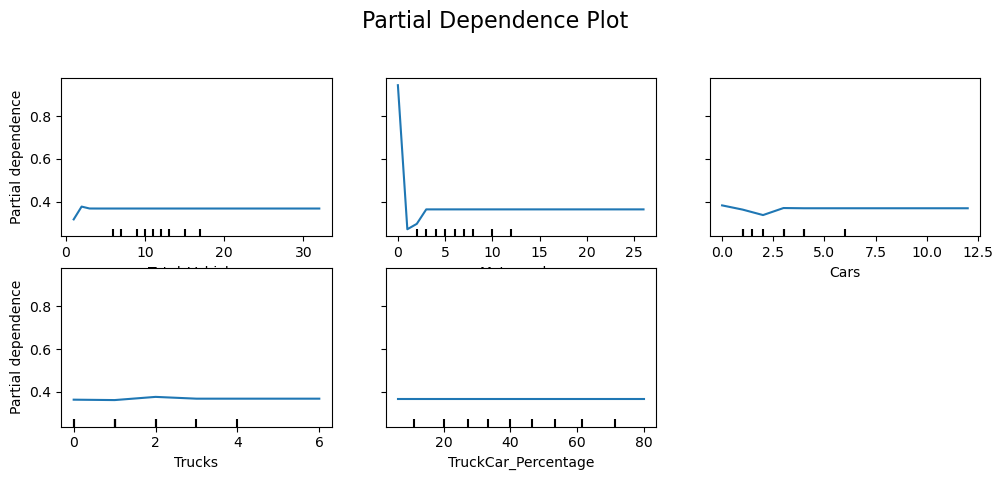

In [70]:
# Tạo figure có kích thước lớn hơn và layout gọn gàng
fig, ax = plt.subplots(figsize=(10, 5))

PartialDependenceDisplay.from_estimator(
    rf_model,
    X,
    features=['Total_Vehicles', 'Motorcycles', 'Cars', 'Trucks', 'TruckCar_Percentage'],
    ax=ax
)

plt.suptitle("Partial Dependence Plot", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Chừa khoảng cho tiêu đề
plt.show()

8. Kiểm tra overfit

In [71]:
scores_log = cross_val_score(log_model, X, y, cv=5)
scores_rf = cross_val_score(rf_model, X, y, cv=5)
print("Cross-validation random forest accuracy:", scores_rf.mean())
print("Cross-validation log accuracy:", scores_log.mean())

Cross-validation random forest accuracy: 0.9905303030303031
Cross-validation log accuracy: 0.825


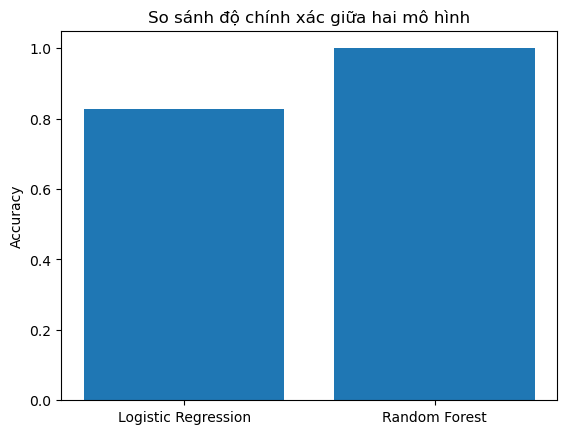

In [72]:
models = ['Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_log),
    accuracy_score(y_test, y_pred_rf)
]

plt.bar(models, accuracies)
plt.title("So sánh độ chính xác giữa hai mô hình")
plt.ylabel("Accuracy")
plt.show()


9. Confusion Matrix

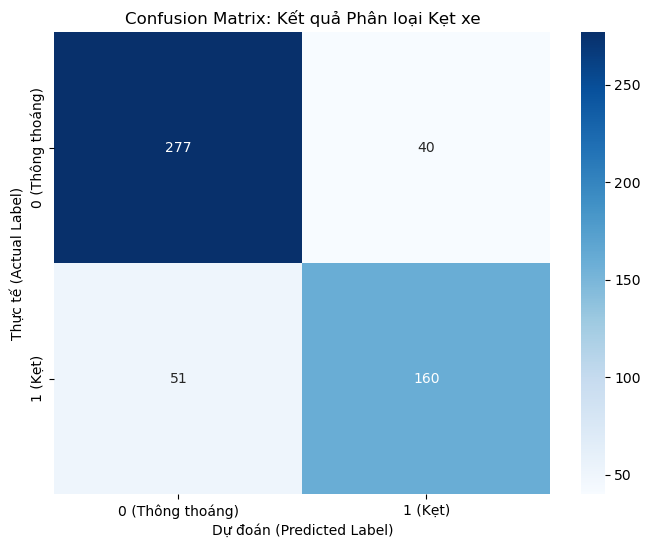


--- BÁO CÁO PHÂN LOẠI (Classification Report) ---
                  precision    recall  f1-score   support

0 (Thông thoáng)       0.84      0.87      0.86       317
         1 (Kẹt)       0.80      0.76      0.78       211

        accuracy                           0.83       528
       macro avg       0.82      0.82      0.82       528
    weighted avg       0.83      0.83      0.83       528



In [77]:
# --- 1. Tính toán Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_log)

# 2. Định nghĩa các nhãn (Tên cột/hàng trên biểu đồ)
class_labels = ['0 (Thông thoáng)', '1 (Kẹt)']

# --- 3. Vẽ biểu đồ nhiệt (Heatmap) ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,              # Hiển thị giá trị số trong ô
    fmt='d',                 # Định dạng số nguyên
    cmap='Blues',            # Sử dụng màu Xanh
    xticklabels=class_labels, # Nhãn trục X (Dự đoán)
    yticklabels=class_labels # Nhãn trục Y (Thực tế)
)
plt.title('Confusion Matrix: Kết quả Phân loại Kẹt xe')
plt.ylabel('Thực tế (Actual Label)')
plt.xlabel('Dự đoán (Predicted Label)')
plt.show()

# --- 4. Hiển thị Báo cáo Phân loại (Tùy chọn) ---
print("\n--- BÁO CÁO PHÂN LOẠI (Classification Report) ---")
print(classification_report(y_test, y_pred_log, target_names=class_labels))

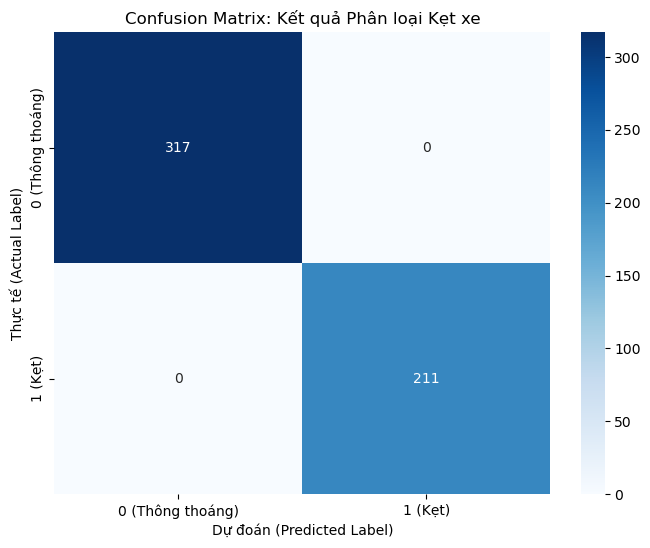


--- BÁO CÁO PHÂN LOẠI (Classification Report) ---
                  precision    recall  f1-score   support

0 (Thông thoáng)       1.00      1.00      1.00       317
         1 (Kẹt)       1.00      1.00      1.00       211

        accuracy                           1.00       528
       macro avg       1.00      1.00      1.00       528
    weighted avg       1.00      1.00      1.00       528



In [ ]:
# --- 1. Tính toán Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_rf)

# 2. Định nghĩa các nhãn (Tên cột/hàng trên biểu đồ)
class_labels = ['0 (Thông thoáng)', '1 (Kẹt)']

# --- 3. Vẽ biểu đồ nhiệt (Heatmap) ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,              # Hiển thị giá trị số trong ô
    fmt='d',                 # Định dạng số nguyên
    cmap='Blues',            # Sử dụng màu Xanh
    xticklabels=class_labels, # Nhãn trục X (Dự đoán)
    yticklabels=class_labels # Nhãn trục Y (Thực tế)
)
plt.title('Confusion Matrix: Kết quả Phân loại Kẹt xe')
plt.ylabel('Thực tế (Actual Label)')
plt.xlabel('Dự đoán (Predicted Label)')
plt.show()

# --- 4. Hiển thị Báo cáo Phân loại (Tùy chọn) ---
print("\n--- BÁO CÁO PHÂN LOẠI (Classification Report) ---")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))